In [3]:
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing 
import tensorflow_datasets as tfds

In [4]:
from tensorflow_examples.models.pix2pix import pix2pix
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [5]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

In [6]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32)/255.0 
    input_mask -= 1
    return input_image, input_mask 

In [7]:
def load_image(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128,128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128,128))

    input_image, input_mask = normalize(input_image, input_mask) 
    return input_image, input_mask 

In [8]:
TRAIN_LENGTH = info.splits['train'].num_examples 
BATCH_SIZE = 64 
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [9]:
train_images = dataset['train'].map(load_image, num_parallel_calls = tf.data.AUTOTUNE)
test_images = dataset['test'].map(load_image, num_parallel_calls = tf.data.AUTOTUNE)

In [10]:
class Augment(tf.keras.layers.Layer): 
    def __init__(self, seed=42):
        super().__init__() 
        self.augment_inputs = preprocessing.RandomFlip(mode='horizontal', seed=seed)
        self.augment_labels = preprocessing.RandomFlip(mode='horizontal', seed=seed)

    def call(self, inputs, labels):
        inputs = self.augment_inputs(inputs) 
        labels = self.augment_labels(labels) 
        return inputs, labels 

In [11]:
train_batches = ( 
    train_images 
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

test_batches = test_images.batch(BATCH_SIZE) 

In [12]:
def display(display_list):
    plt.figure(figsize=(15,15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1) 
        plt.title(title[i]) 
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

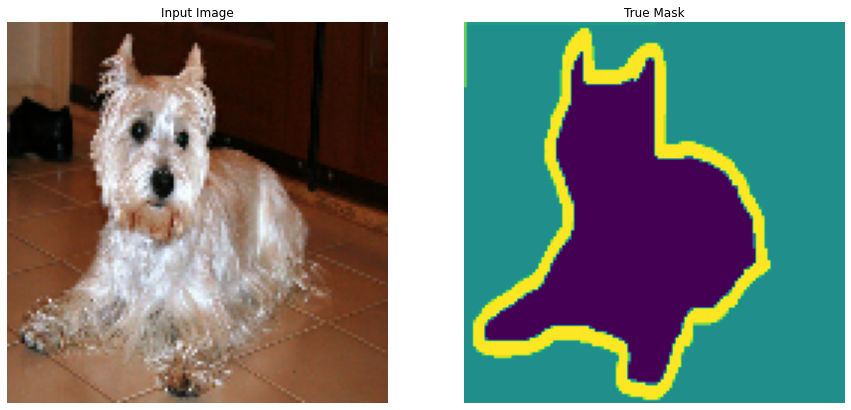

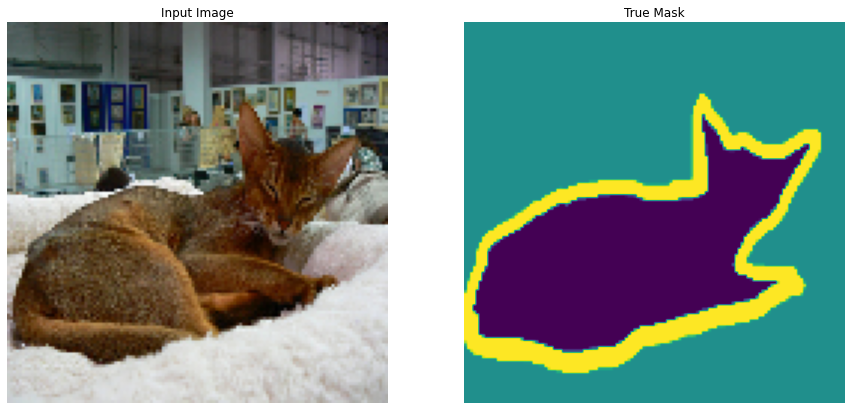

In [13]:
for images, masks in train_batches.take(2):
    sample_image, sample_mask = images[0], masks[0] 
    display([sample_image, sample_mask]) 

In [14]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128,128,3], include_top=False)

layer_names = [ 
    'block_1_expand_relu', 
    'block_3_expand_relu', 
    'block_6_expand_relu',
    'block_13_expand_relu',
    'block_16_project',
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

down_stack = tf.keras.Model(inputs = base_model.input, outputs=base_model_outputs)
down_stack.trainable = False

In [15]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [16]:
def unet_model(output_channels:int):
    inputs = tf.keras.layers.Input(shape=[128,128,3])
    skips = down_stack(inputs) 
    x = skips[-1] 
    skips = reversed(skips[:-1])

    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate() 
        x = concat([x, skip])

    last = tf.keras.layers.Conv2DTranspose( 
        filters = output_channels, kernel_size=3, strides=2, padding='same'
    )

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x) 

In [17]:
OUTPUT_CLASSES = 3 

model = unet_model(output_channels=OUTPUT_CLASSES)
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [18]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [19]:
def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask, create_mask(model.predict(sample_image[tf.newaxis, ...]))])

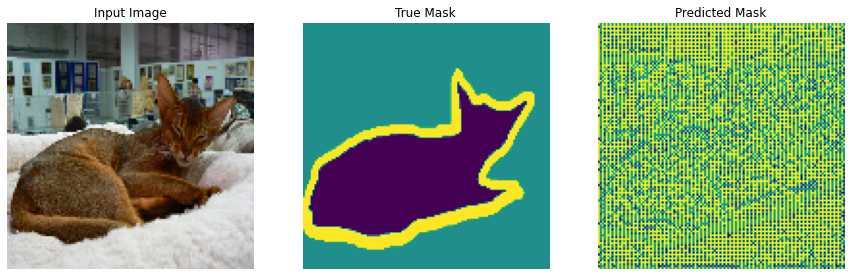

In [20]:
show_predictions()

In [21]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True) 
        show_predictions() 
        print('\nSample Prediction after epoch {}\n'.format(epoch+1))

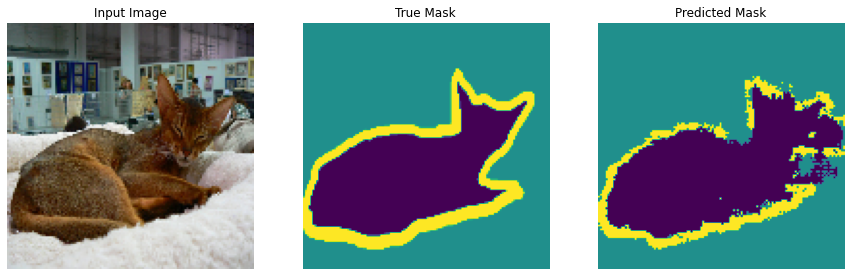


Sample Prediction after epoch 3

57/57 [==============================] - 212s 4s/step - loss: 0.2815 - accuracy: 0.8835 - val_loss: 0.2920 - val_accuracy: 0.8823
Epoch 4/20
40/57 [====================>.........] - ETA: 1:03 - loss: 0.2685 - accuracy: 0.8881

KeyboardInterrupt: 

In [22]:
EPOCHS = 20
VAL_SUBSPLITS = 5 
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_batches, epochs=EPOCHS, steps_per_epoch=STEPS_PER_EPOCH, validation_steps=VALIDATION_STEPS, validation_data=test_batches, callbacks=[DisplayCallback()])

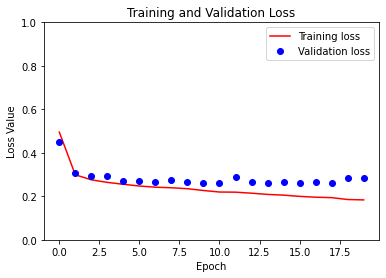

In [ ]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

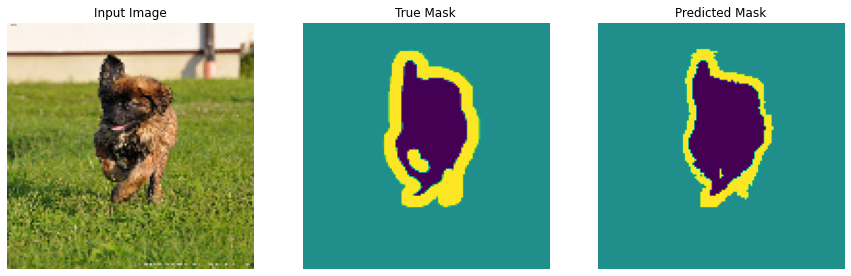

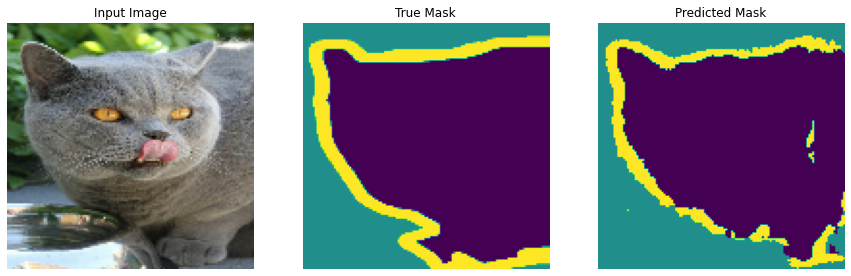

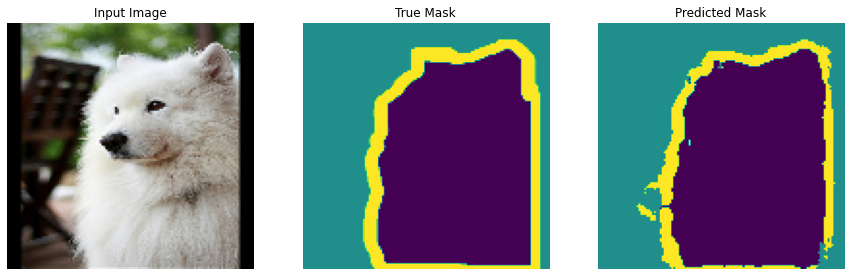

In [ ]:
show_predictions(test_batches, 3)